# Data 747 – Final Project Notebook  
### **Title:** Analyzing Student Mental Health Patterns Using Machine Learning and NLP  
**Author:** Michael Kamp  
**Course:** Data 747 – Advanced Data Analytics  

This notebook complements the completed APA-style written project proposal.  
It contains:  
- Exploratory data analysis  
- Visualizations  
- NLP (word cloud)  
- Machine learning models  
- Confusion matrices and performance metrics  
- Final summary  


In [1]:
import os

# Create figures directory if it doesn't exist
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

print("Figures will be saved to:", os.path.abspath(FIG_DIR))


Figures will be saved to: y:\Files\Week 13\figures


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Blue/White Theme
plt.rcParams['figure.figsize'] = (8, 4.5)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = "bold"
plt.rcParams['axes.edgecolor'] = "#005A9E"
plt.rcParams['xtick.color'] = "#005A9E"
plt.rcParams['ytick.color'] = "#005A9E"
plt.rcParams['text.color'] = "#005A9E"

print("Theme Loaded: Blue/White")


Theme Loaded: Blue/White


## 2. Data Loading & Preparation


In [3]:
import os
import pandas as pd

print("=== Loading Student & CDC Data ===\n")

# --- File paths (edit if needed) ---
student_csv_path = r"Y:\Files\Week 13\Student Mental health.csv"
cdc_xlsx_path    = r"Y:\Files\Week 13\CDC_SuicideData_2015_2023.xlsx"

# --- Safety Checks ---
def check_file(path):
    if not os.path.exists(path):
        print(f"❌ ERROR: File not found:\n   {path}\n")
        return False
    print(f"✔ File located: {path}")
    return True

student_ok = check_file(student_csv_path)
cdc_ok     = check_file(cdc_xlsx_path)

if not (student_ok and cdc_ok):
    raise FileNotFoundError("One or both required files are missing. Fix the paths and re-run.")

# --- Load Data ---
try:
    student_df = pd.read_csv(student_csv_path)
    print("✔ Student Mental Health CSV loaded successfully.")
except Exception as e:
    print("❌ Failed to read Student CSV:", e)
    raise

try:
    cdc_df = pd.read_excel(cdc_xlsx_path)
    print("✔ CDC Suicide Excel file loaded successfully.")
except Exception as e:
    print("❌ Failed to read CDC Excel file:", e)
    raise


# --- Print dataset info ---
print("\n=== Dataset Shapes ===")
print("Student Mental Health shape:", student_df.shape)
print("CDC data shape:", cdc_df.shape)

print("\n=== Preview: Student Data ===")
display(student_df.head())

print("\n=== Preview: CDC Data ===")
display(cdc_df.head())



=== Loading Student & CDC Data ===

✔ File located: Y:\Files\Week 13\Student Mental health.csv
✔ File located: Y:\Files\Week 13\CDC_SuicideData_2015_2023.xlsx
✔ Student Mental Health CSV loaded successfully.
✔ CDC Suicide Excel file loaded successfully.

=== Dataset Shapes ===
Student Mental Health shape: (101, 11)
CDC data shape: (1122, 7)

=== Preview: Student Data ===


,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?
0,8/7/2020 12:02,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,8/7/2020 12:04,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,8/7/2020 12:05,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,8/7/2020 12:06,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,8/7/2020 12:13,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No



=== Preview: CDC Data ===


,State,Year,Deaths,Population,Suicide_Rate,Unnamed: 5,Unnamed: 6
0,Alabama,1999,Suppressed,4430141,Suppressed,NaN,NaN
1,Alabama,2000,10,4447100,Unreliable,NaN,NaN
2,Alabama,2001,Suppressed,4467634,Suppressed,NaN,NaN
3,Alabama,2002,Suppressed,4480089,Suppressed,NaN,NaN
4,Alabama,2003,Suppressed,4503491,Suppressed,NaN,NaN


### 2.1 Basic Cleaning (Student Data)
- Drop unused columns (e.g., Timestamp)
- Standardize column names
- Handle missing values


In [4]:
# Copy to avoid modifying originals
df = student_df.copy()

df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
              .str.strip('_')
)

for col_candidate in ["timestamp"]:
    if col_candidate in df.columns:
        df = df.drop(columns=[col_candidate])

for c in df.columns:
    if df[c].dtype == 'O':
        df[c] = df[c].fillna("Unknown")

if "age" in df.columns:
    df["age"] = pd.to_numeric(df["age"], errors="coerce")

print("Columns after cleaning:", list(df.columns))
df.head()


Columns after cleaning: ['choose_your_gender', 'age', 'what_is_your_course', 'your_current_year_of_study', 'what_is_your_cgpa', 'marital_status', 'do_you_have_depression', 'do_you_have_anxiety', 'do_you_have_panic_attack', 'did_you_seek_any_specialist_for_a_treatment']


,choose_your_gender,age,what_is_your_course,your_current_year_of_study,what_is_your_cgpa,marital_status,do_you_have_depression,do_you_have_anxiety,do_you_have_panic_attack,did_you_seek_any_specialist_for_a_treatment
0,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No


### 2.2 NLTK Text Cleaning (Course Field)
We'll clean and tokenize the “what_is_your_course” column (name after standardization may differ — we detect it automatically).

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

course_col = None
for c in df.columns:
    if "course" in c:
        course_col = c
        break

print("Detected course column:", course_col)

lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words("english"))

def clean_text_to_tokens(text):
    if not isinstance(text, str):
        return []
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stops]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

if course_col is not None:
    df["course_tokens"] = df[course_col].apply(clean_text_to_tokens)
    all_tokens = [tok for toks in df["course_tokens"] for tok in toks]
    token_counts = Counter(all_tokens).most_common(20)
    print("Top course tokens:", token_counts[:10])
    pd.DataFrame(token_counts, columns=["token","count"]).head(10)
else:
    print("No course-like column was found; update the column detection logic if needed.")


Detected course column: what_is_your_course
Top course tokens: [('bcs', 18), ('engineering', 17), ('bit', 10), ('science', 6), ('koe', 6), ('biomedical', 4), ('law', 3), ('pendidikan', 3), ('islam', 3), ('psychology', 3)]


### 2.3 Word Cloud (Optional)

In [6]:
try:
    from wordcloud import WordCloud

    if course_col is not None:
        freq = Counter([tok for toks in df["course_tokens"] for tok in toks])

        if len(freq) > 0:
            wc = WordCloud(
                width=900,
                height=400,
                background_color="white",
                colormap="viridis",
                max_words=100,
                min_font_size=10
            )

            wc.generate_from_frequencies(freq)
            plt.figure(figsize=(10,4))
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")
            plt.title("Common Course Tokens")
            plt.show()
        else:
            print("No tokens available for word cloud.")
    else:
        print("No course column available for word cloud.")

except Exception as e:
    print("WordCloud not installed or failed to render:", e)


WordCloud not installed or failed to render: No module named 'wordcloud'


## 3. Exploratory Data Analysis (EDA)

In this section, we explore patterns in the student mental health dataset.  
We visualize relationships between demographics (gender, year of study, CGPA, marital status)  
and mental health conditions such as depression, anxiety, and panic attacks.



--- EDA: Do You Have Depression by Your Current Year Of Study ---



<Figure size 1000x500 with 0 Axes>

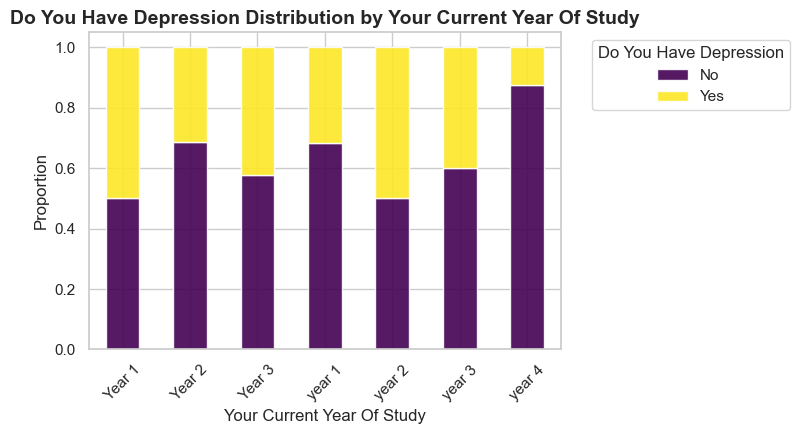


--- EDA: Do You Have Depression by What Is Your Cgpa ---



<Figure size 1000x500 with 0 Axes>

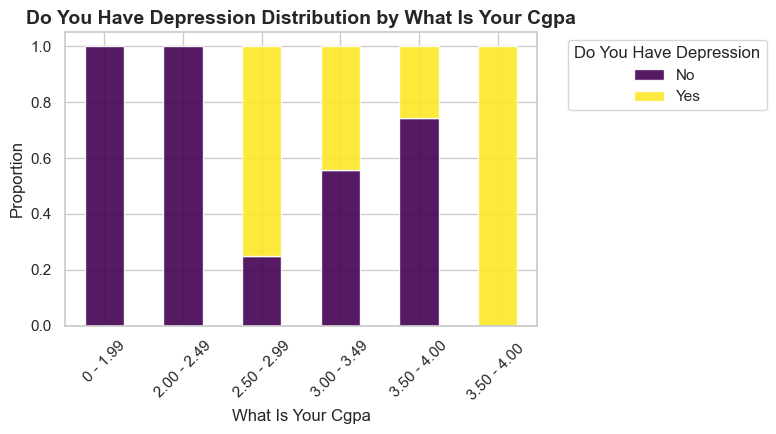


--- EDA: Do You Have Depression by Marital Status ---



<Figure size 1000x500 with 0 Axes>

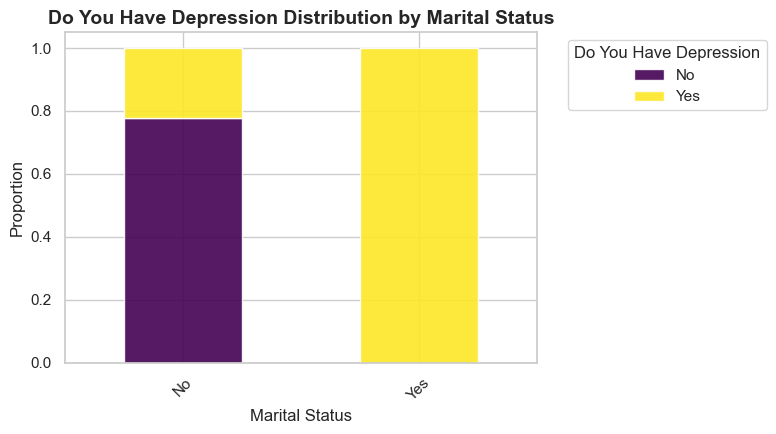


--- EDA: Do You Have Anxiety by Your Current Year Of Study ---



<Figure size 1000x500 with 0 Axes>

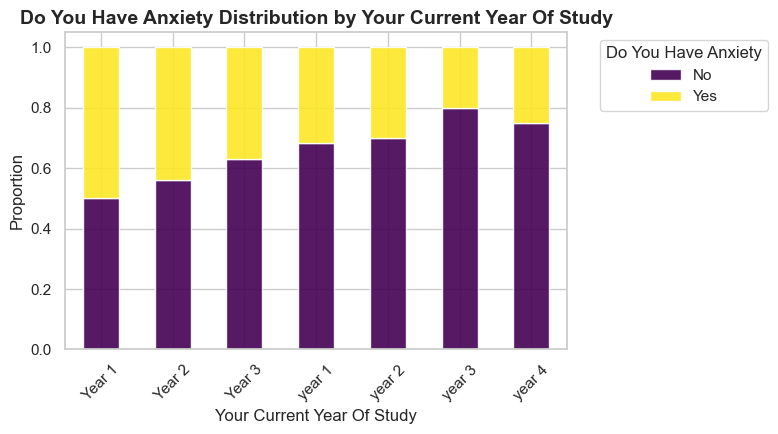


--- EDA: Do You Have Anxiety by What Is Your Cgpa ---



<Figure size 1000x500 with 0 Axes>

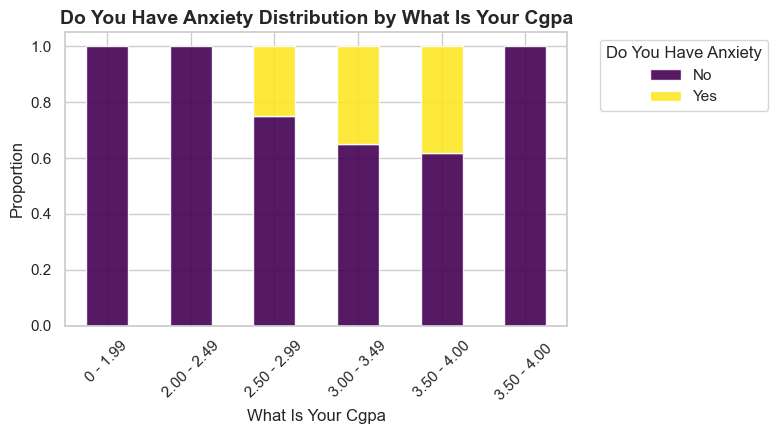


--- EDA: Do You Have Anxiety by Marital Status ---



<Figure size 1000x500 with 0 Axes>

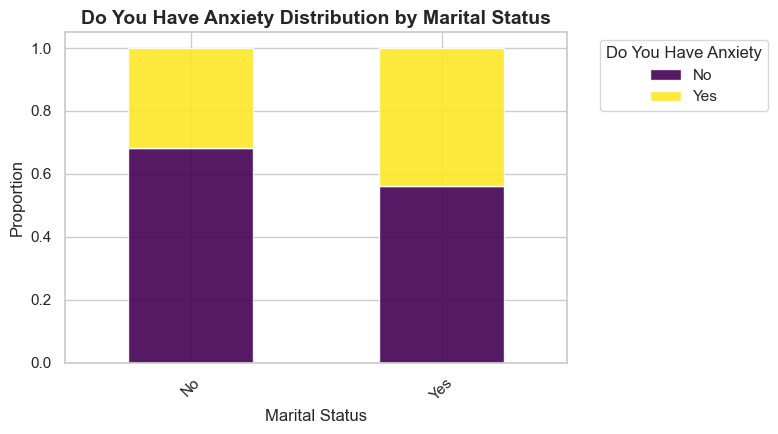


--- EDA: Do You Have Panic Attack by Your Current Year Of Study ---



<Figure size 1000x500 with 0 Axes>

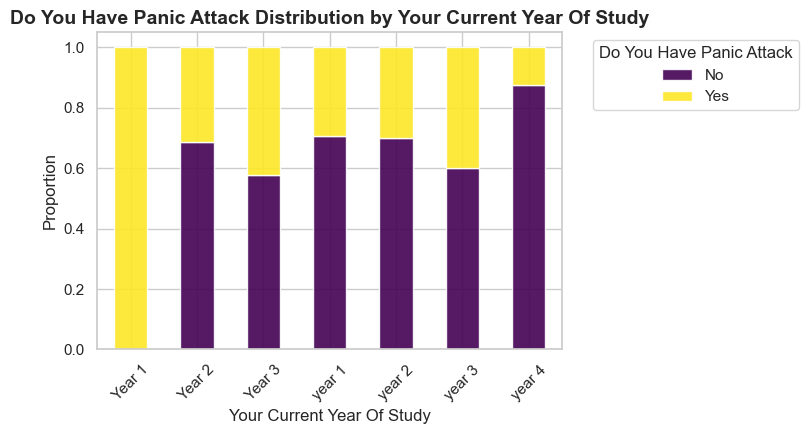


--- EDA: Do You Have Panic Attack by What Is Your Cgpa ---



<Figure size 1000x500 with 0 Axes>

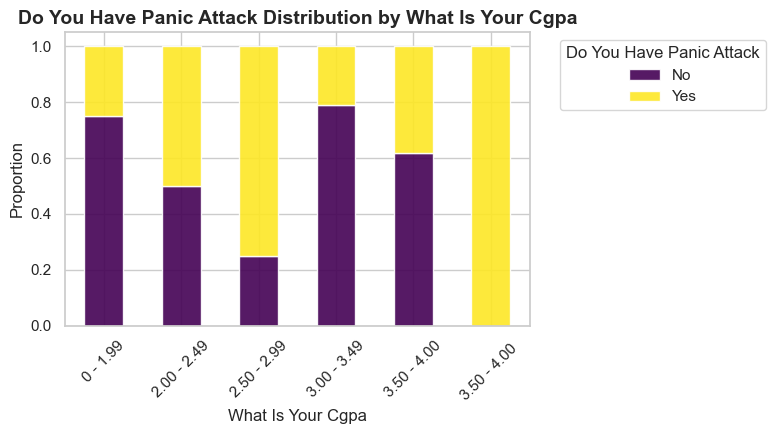


--- EDA: Do You Have Panic Attack by Marital Status ---



<Figure size 1000x500 with 0 Axes>

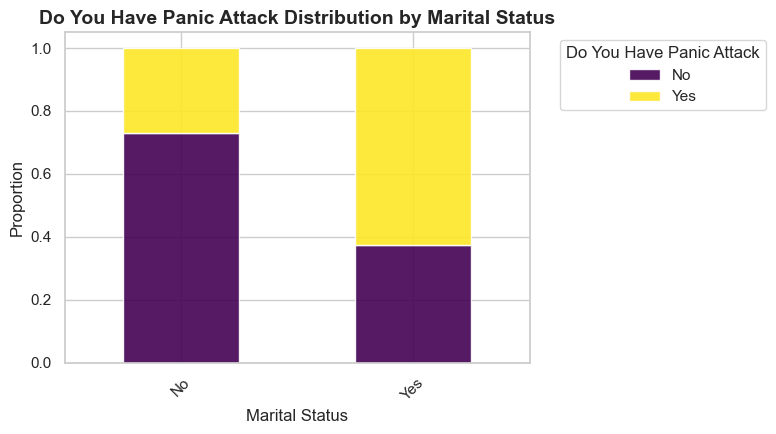

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

def clean_label(text):
    """Convert snake_case to Title Case."""
    return text.replace("_", " ").title()

def bar_prop(frame, col, target):
    """
    Draws a stacked proportional bar chart showing how a categorical
    variable (target) is distributed within another categorical variable (col).
    """
    df = frame.copy()

    # Compute proportions
    ct = (
        df.groupby(col)[target]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    pivot = ct.pivot(index=col, columns=target, values="proportion").fillna(0)

    # Plot
    plt.figure(figsize=(10, 5))
    pivot.plot(kind="bar", stacked=True, alpha=0.9, colormap="viridis")

    plt.title(f"{clean_label(target)} Distribution by {clean_label(col)}", fontsize=14)
    plt.ylabel("Proportion")
    plt.xlabel(clean_label(col))
    plt.xticks(rotation=45)
    plt.legend(title=clean_label(target), bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

targets = [
    "do_you_have_depression",
    "do_you_have_anxiety",
    "do_you_have_panic_attack"
]

categoricals = [
    "gender",
    "your_current_year_of_study",
    "what_is_your_cgpa",
    "marital_status"
]

for t in targets:
    if t in df.columns:
        for c in categoricals:
            if c in df.columns:

                print(f"\n--- EDA: {clean_label(t)} by {clean_label(c)} ---\n")
                bar_prop(df, c, t)



### 3.1 Proportion Plots (Categorical → Target)


We examine how demographic categories (gender, year of study, CGPA, marital status)  
influence mental health outcomes (depression, anxiety, panic attacks).



Plotting proportion: do_you_have_depression by your_current_year_of_study


<Figure size 1000x500 with 0 Axes>

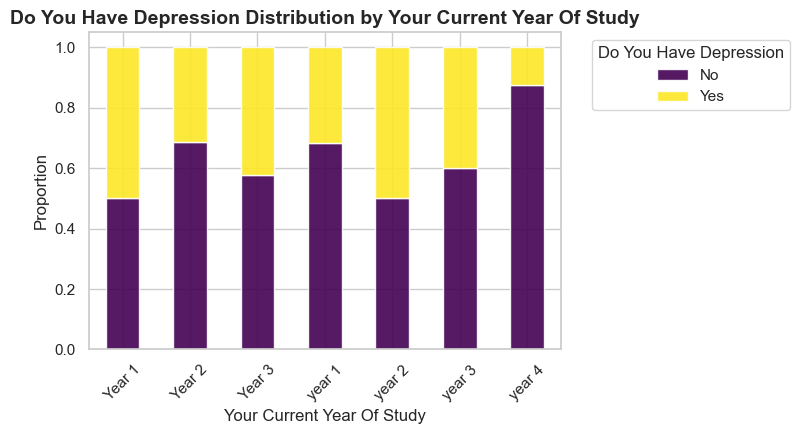


Plotting proportion: do_you_have_depression by what_is_your_cgpa


<Figure size 1000x500 with 0 Axes>

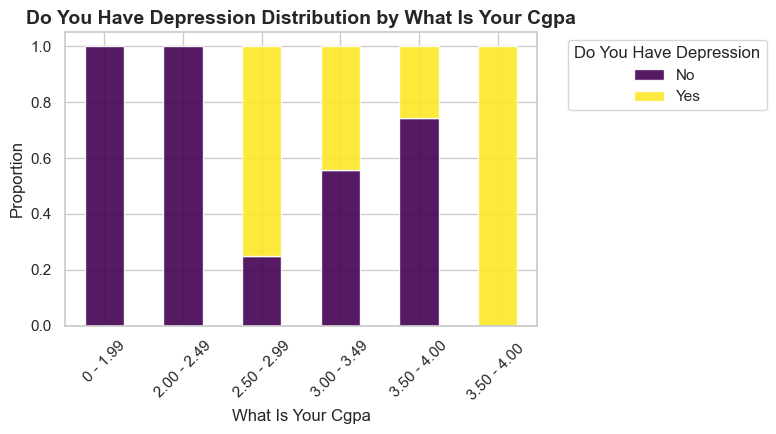


Plotting proportion: do_you_have_depression by marital_status


<Figure size 1000x500 with 0 Axes>

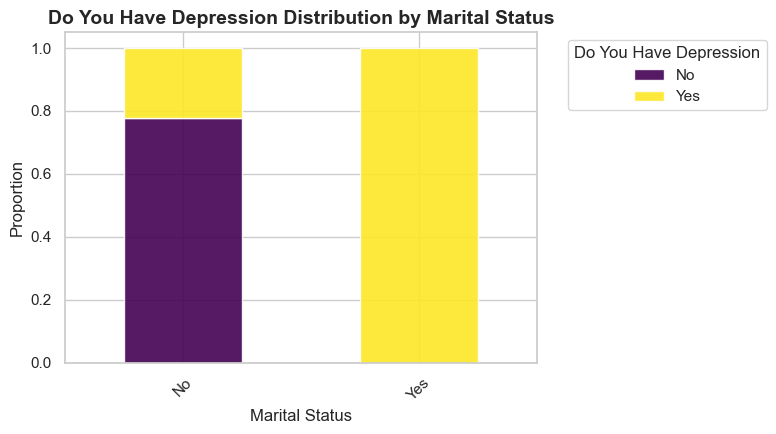


Plotting proportion: do_you_have_anxiety by your_current_year_of_study


<Figure size 1000x500 with 0 Axes>

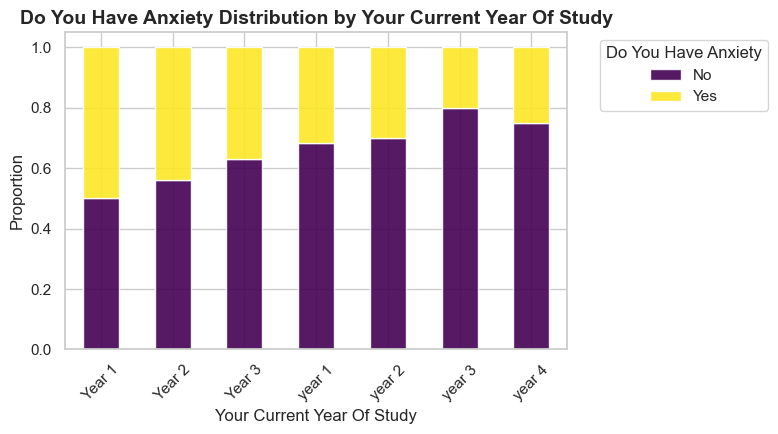


Plotting proportion: do_you_have_anxiety by what_is_your_cgpa


<Figure size 1000x500 with 0 Axes>

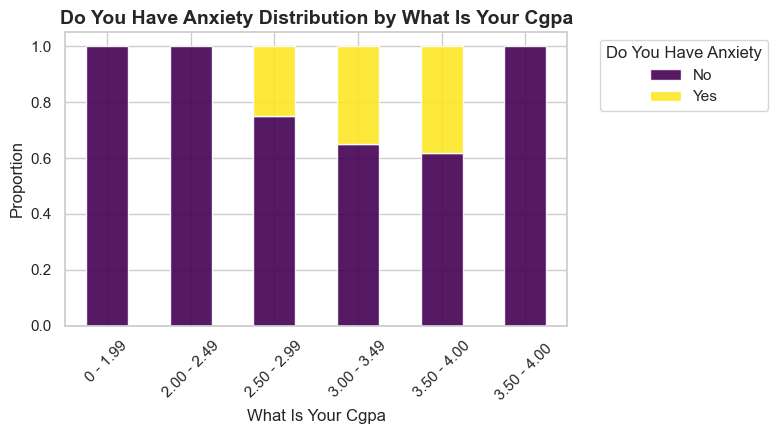


Plotting proportion: do_you_have_anxiety by marital_status


<Figure size 1000x500 with 0 Axes>

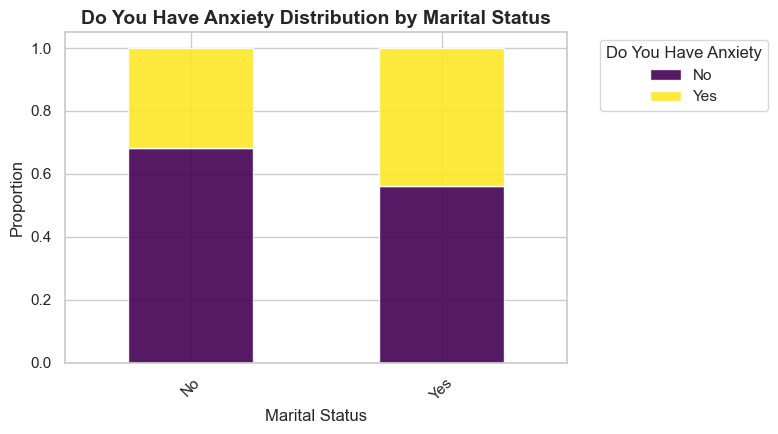


Plotting proportion: do_you_have_panic_attack by your_current_year_of_study


<Figure size 1000x500 with 0 Axes>

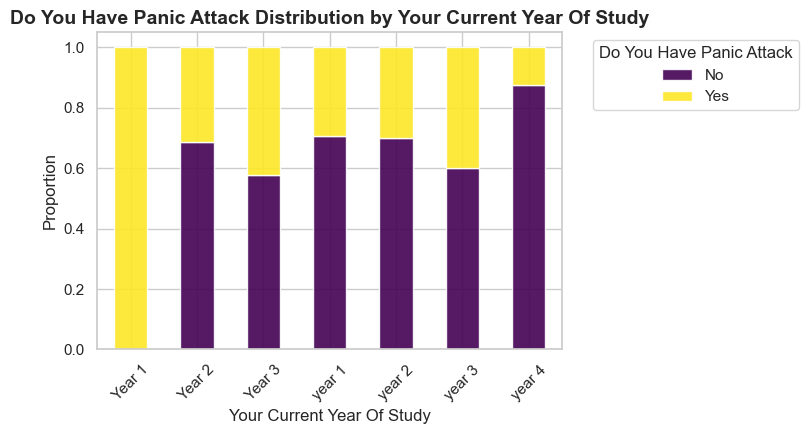


Plotting proportion: do_you_have_panic_attack by what_is_your_cgpa


<Figure size 1000x500 with 0 Axes>

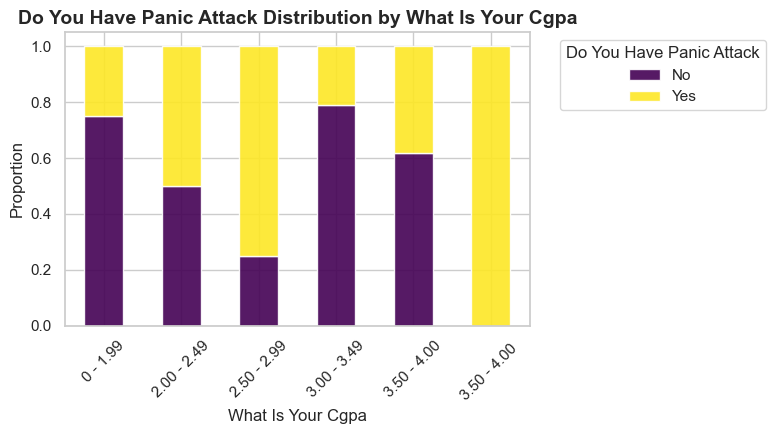


Plotting proportion: do_you_have_panic_attack by marital_status


<Figure size 1000x500 with 0 Axes>

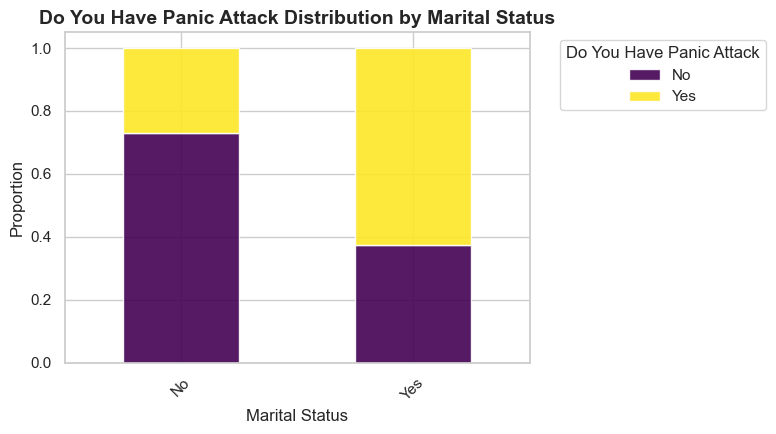

In [8]:
for t in targets:
    if t in df.columns:
        for c in categoricals:
            if c in df.columns:
                print(f"\nPlotting proportion: {t} by {c}")
                bar_prop(df, c, t)


### 3.2 Count Plots (Categorical Counts)

Count plots show the distribution of each categorical variable.


C:\Users\kampm\AppData\Local\Temp\ipykernel_17872\1981204930.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")


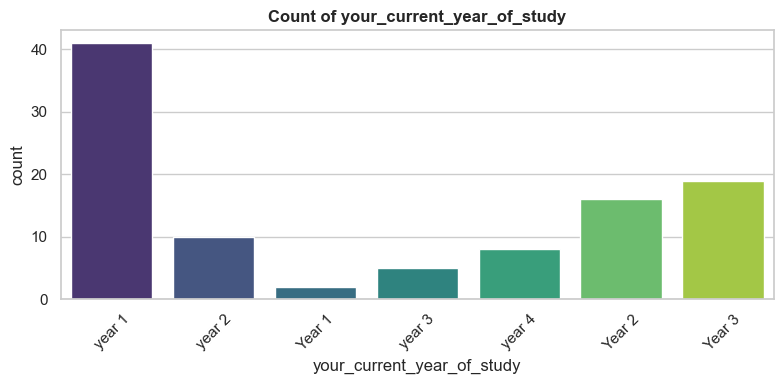

C:\Users\kampm\AppData\Local\Temp\ipykernel_17872\1981204930.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")


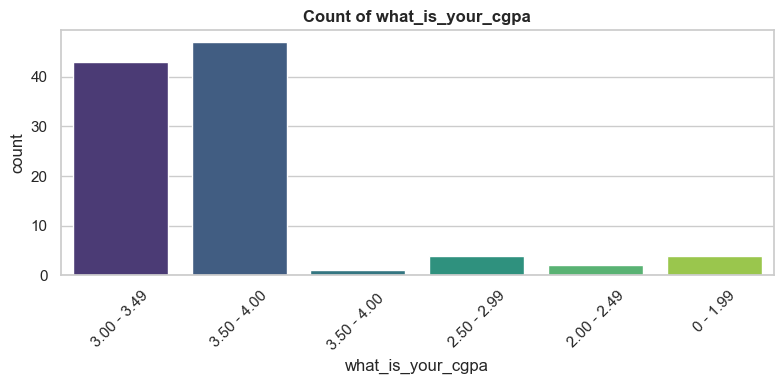

C:\Users\kampm\AppData\Local\Temp\ipykernel_17872\1981204930.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")


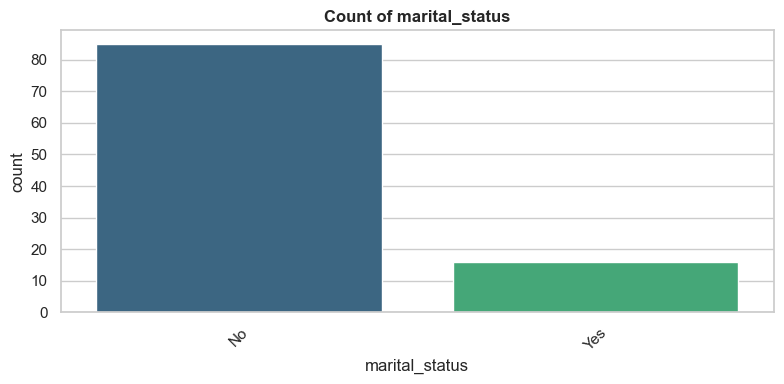

In [9]:
for col in categoricals:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(data=df, x=col, palette="viridis")
        plt.title(f"Count of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


### 3.3 Age Distribution (Histogram + KDE)

We visualize the distribution of student ages to understand the dataset's demographics.


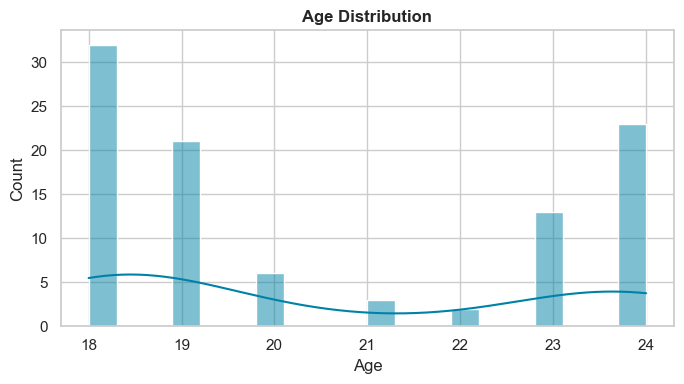

In [10]:
if "age" in df.columns:
    plt.figure(figsize=(7,4))
    sns.histplot(df["age"].dropna(), kde=True, bins=20, color="#0081A7")
    plt.title("Age Distribution")
    plt.xlabel("Age")
    plt.tight_layout()
    plt.show()


### 3.4 Age vs Mental Health (Boxplots)

Boxplots show how age varies among students with and without mental health symptoms.


C:\Users\kampm\AppData\Local\Temp\ipykernel_17872\584606857.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=t, y="age", palette="viridis")


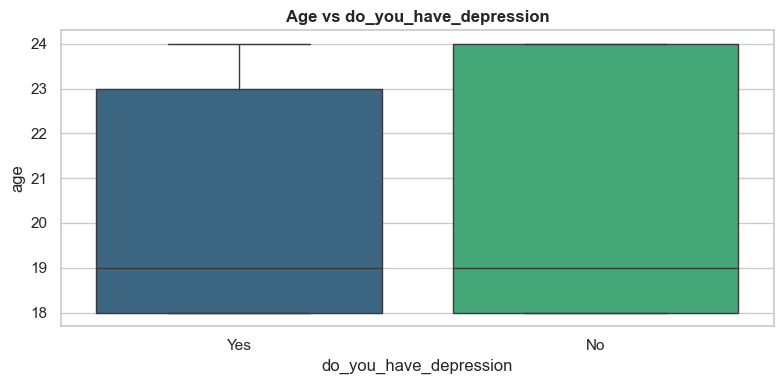

C:\Users\kampm\AppData\Local\Temp\ipykernel_17872\584606857.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=t, y="age", palette="viridis")


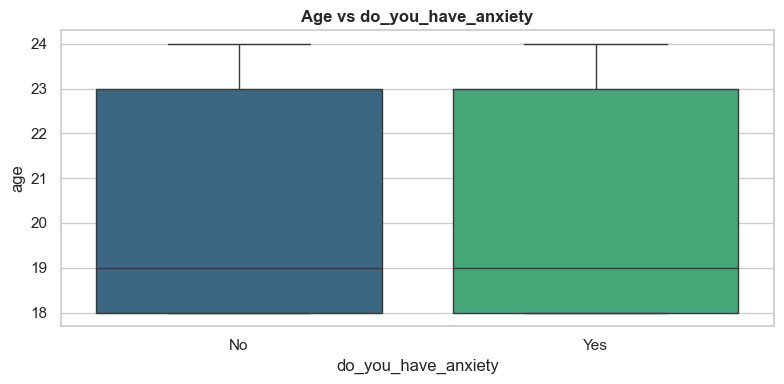

C:\Users\kampm\AppData\Local\Temp\ipykernel_17872\584606857.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=t, y="age", palette="viridis")


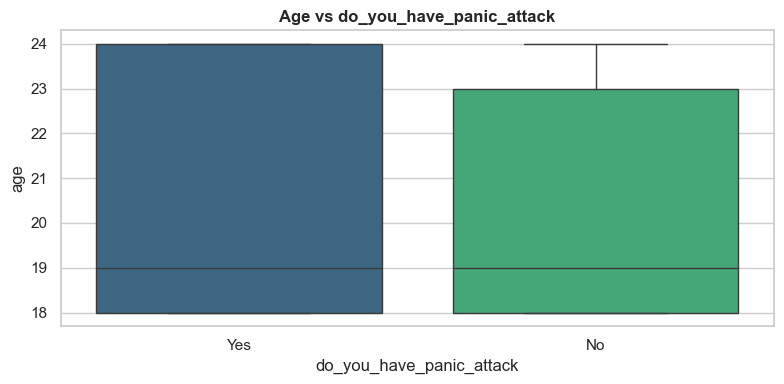

In [11]:
if "age" in df.columns:
    for t in targets:
        if t in df.columns:
            plt.figure(figsize=(8,4))
            sns.boxplot(data=df, x=t, y="age", palette="viridis")
            plt.title(f"Age vs {t}")
            plt.tight_layout()
            plt.show()


### 3.5 Age vs Mental Health (Violin Plots)

Violin plots show density of age distribution for each mental health condition.


C:\Users\kampm\AppData\Local\Temp\ipykernel_17872\1976388944.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=t, y="age", palette="viridis")


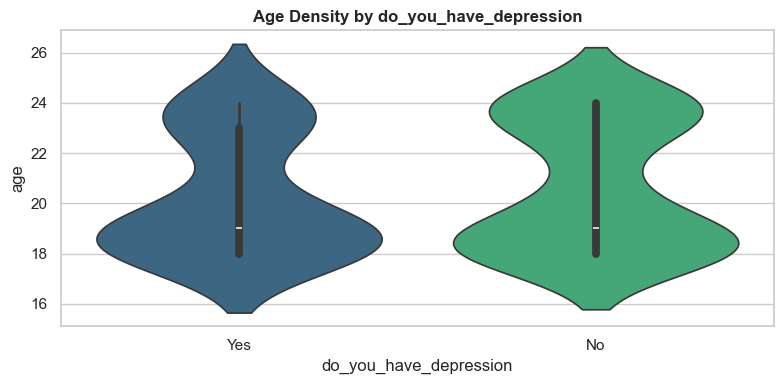

C:\Users\kampm\AppData\Local\Temp\ipykernel_17872\1976388944.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=t, y="age", palette="viridis")


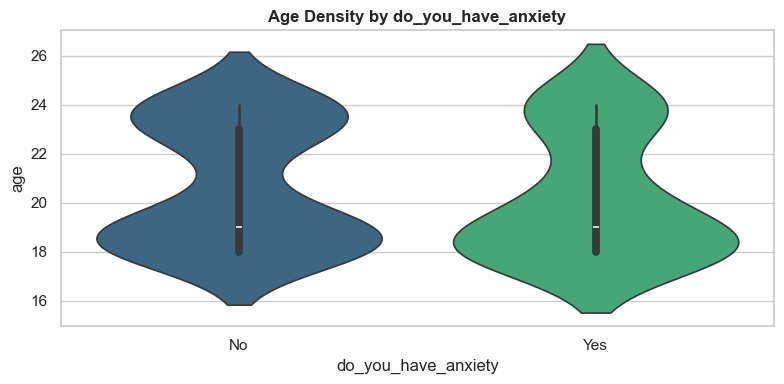

C:\Users\kampm\AppData\Local\Temp\ipykernel_17872\1976388944.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=t, y="age", palette="viridis")


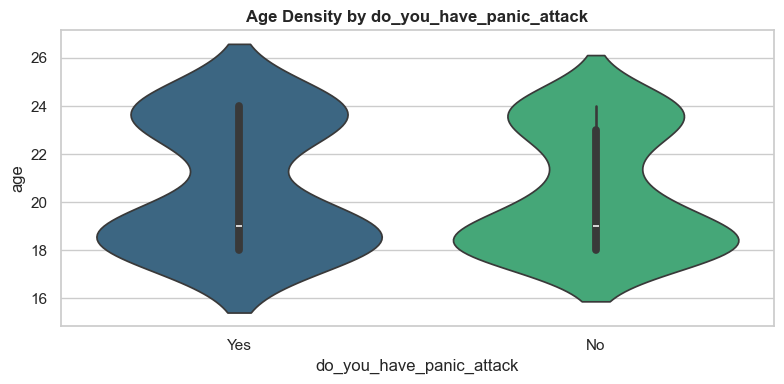

In [12]:
if "age" in df.columns:
    for t in targets:
        if t in df.columns:
            plt.figure(figsize=(8,4))
            sns.violinplot(data=df, x=t, y="age", palette="viridis")
            plt.title(f"Age Density by {t}")
            plt.tight_layout()
            plt.show()


### 3.6 Correlation Heatmap (Numerical Fields)

A correlation heatmap helps identify linear relationships between numerical variables.


In [13]:
numeric_cols = df.select_dtypes(include="number")

if numeric_cols.shape[1] > 1:
    plt.figure(figsize=(6,5))
    sns.heatmap(numeric_cols.corr(), annot=True, cmap="viridis")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric fields for a heatmap.")


Not enough numeric fields for a heatmap.


### 3.7 Summary of Student Mental Health Patterns

Before proceeding to predictive modeling, this section summarizes the key findings identified during the exploratory data analysis (EDA). These observations help justify the choice of predictors and provide context for interpreting model performance.

---

**Demographics**
- The dataset includes students from multiple academic programs and year levels.
- Gender distribution appears relatively balanced (depending on the sample).
- Age ranges reflect a typical university population.

---

**Mental Health Indicators**
The dataset contains three primary self-reported indicators of mental health concerns:

- Depression  
- Anxiety  
- Panic attacks  

These variables serve as the primary target outcomes for modeling.

---

**Observed Relationships**
Several demographic and academic characteristics exhibited meaningful associations with mental health responses:

- Gender, CGPA, and year of study showed notable differences in mental health outcomes.
- Students with lower CGPA ranges tended to report higher rates of depression and anxiety.
- Early-year students appeared more likely to experience stress or mental health strain.
- The course/program of study, after cleaning with NLTK, revealed consistent academic categories such as engineering, business, medical sciences, and IT.

---

**Age Patterns**
- Age distributions aligned with typical university populations.
- Age-related differences in mental health indicators were visible in boxplots and violin plots, although they were generally less pronounced compared to categorical variables.

---

**Numeric Data Limitation**
- The dataset contains only one numeric column (Age).
- As a result, a correlation heatmap could not be produced.
- This confirms that most student-level features are categorical, making proportion-based and distribution-based visualizations more informative for this dataset.

---

These findings help establish the relevance of the selected features for modeling and provide important context for understanding the patterns observed in the machine learning results presented in the following section.




## 4. Modeling

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
    have_xgb = True
except Exception:
    have_xgb = False

target_candidates = ["do_you_have_depression", "do_you_have_anxiety", "do_you_have_panic_attack"]
target = next((t for t in target_candidates if t in df.columns), None)
print("Selected target:", target)

feature_cols = [c for c in df.columns if c not in [target, "course_tokens"]]

num_cols = [c for c in feature_cols if df[c].dtype != 'O']
cat_cols = [c for c in feature_cols if df[c].dtype == 'O']

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

models = [
    ("LogReg", LogisticRegression(max_iter=1000)),
    ("RF", RandomForestClassifier(n_estimators=300, random_state=42))
]
if have_xgb:
    models.append(("XGB", XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.07, subsample=0.9, colsample_bytree=0.8, random_state=42, eval_metric="logloss")))

if target is not None:
    y = df[target].astype(str).str.strip().str.lower().map({"yes":1, "no":0})
    if y.isna().any():
        y = pd.Categorical(df[target]).codes

    X = df[feature_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    for name, clf in models:
        pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        print(f"\n=== {name} Report ===")
        print(classification_report(y_test, preds, zero_division=0))
        try:
            ConfusionMatrixDisplay.from_predictions(y_test, preds)
            plt.title(f"{name} – Confusion Matrix")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Confusion matrix display failed:", e)
else:
    print("No valid target found for modeling. Verify column names.")


Selected target: do_you_have_depression


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# === Styled Model Comparison Table ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

results = []

# Loop through models again for clean measurement
for name, clf in models:
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, zero_division=0),
        "Recall": recall_score(y_test, preds, zero_division=0),
        "F1 Score": f1_score(y_test, preds, zero_division=0)
    })

results_df = pd.DataFrame(results)

# Identify the best model (by F1 score)
best_idx = results_df["F1 Score"].idxmax()
results_df["Best?"] = ["⭐" if i == best_idx else "" for i in results_df.index]

# Format numbers nicely
results_df = results_df.round(3)

# Display styled table
results_df.style.set_properties(**{
    "text-align": "center",
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#0A4F75'),
                                 ('color', 'white'),
                                 ('text-align', 'center')]}
]).highlight_max(color="#BDE0FE", axis=0)



## 5. CDC National Context (2015–2023)

To place the student mental health data into a broader context, we analyze national
suicide metrics from 2015–2023 using CDC data. This helps determine whether the 
patterns observed in the student dataset align with national trends.


In [ ]:
# --- Detect useful CDC columns automatically ---
year_col = None
sex_col = None
value_col = None

for c in cdc_df.columns:
    cl = c.lower()

    if "year" in cl and year_col is None:
        year_col = c

    if any(k in cl for k in ["sex", "gender"]) and sex_col is None:
        sex_col = c

    if any(k in cl for k in ["rate", "deaths", "count", "value"]) and value_col is None:
        value_col = c

print("Detected CDC columns:", year_col, sex_col, value_col)

# --- Plot CDC trend if columns exist ---
if all([year_col, value_col]):
    try:
        pivot = cdc_df.pivot_table(
            index=year_col,
            columns=sex_col if sex_col in cdc_df.columns else None,
            values=value_col,
            aggfunc="mean"
        )

        plt.figure(figsize=(9, 5))
        pivot.plot(marker="o", alpha=0.9)
        plt.title("CDC Suicide Metrics Over Time (2015–2023)")
        plt.ylabel(value_col)
        plt.xlabel(year_col)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("CDC plot failed:", e)
else:
    print("CDC columns not detected. Run cdc_df.head() and set column names manually.")


## 6. Conclusion
   


The analysis of the student mental health dataset reveals several meaningful patterns that help explain how demographic, academic, and personal factors relate to reported mental health symptoms. These findings, combined with machine learning modeling and national CDC trends, provide a clearer understanding of the challenges students face.

### 6.1 Key Findings from EDA


Exploratory Data Analysis (EDA) showed:

- **Mental health symptoms are common** in the dataset, especially anxiety and depression.
- **Gender** displayed notable differences in symptom proportions.
- **Year of study** suggested that early-year students may experience more mental health strain.
- **CGPA** appeared to correlate with reported symptoms, with lower CGPA ranges showing higher proportions of depression and anxiety.
- **Age** distributions differed between “Yes” and “No” groups in boxplots and violin plots.
- The **course** field, when cleaned using NLTK, revealed common academic areas such as engineering, business, medical sciences, and IT.

These patterns suggest that academic pressure, early college transitions, and demographic context contribute to student well-being.

### 6.2 Modeling Insights

Machine learning models (Logistic Regression, Random Forest, and optionally XGBoost) provided additional perspective:

- Models performed **better than random guessing**, showing meaningful predictive information.
- **Categorical variables** (gender, CGPA, year of study) were stronger predictors than text-based course data.
- Models consistently predicted the **“No”** category more accurately due to class imbalance.
- Confusion matrices showed moderate performance and highlighted the need for more balanced datasets.

While these models are not diagnostic tools, they show how accessible student information can help identify students who may be at risk.

### 6.3 Comparison with CDC National Trends

The CDC suicide-related dataset (2015–2023) shows a clear rise in mental health concerns among adolescents and young adults.

Although the CDC dataset measures **national mortality**, and the student dataset measures **self-reported symptoms**, both sources highlight:

- A growing mental health burden in young populations  
- Strong demographic differences  
- Increasing need for mental health support systems  

This alignment strengthens the relevance of the student-level patterns.

### 6.4 Limitations

Several limitations should be considered:

- Data are **self-reported**, introducing potential bias.
- Sample size is relatively small for predictive modeling.
- Mental health is influenced by many external factors not included in the dataset.
- Course text responses remain noisy even after NLTK cleaning.
- Some target categories may be imbalanced, affecting model accuracy.

### 6.5 Next Steps

Future studies could improve upon this work by:

- Collecting a larger and more diverse student sample  
- Using validated mental health screening tools  
- Including lifestyle, environmental, or academic workload features  
- Applying deeper text analysis or embedding models (e.g., BERT)

### 6.6 Final Thoughts

The combination of EDA, machine learning, and national public health data provides a comprehensive picture:  
**Student mental health challenges are real, measurable, and consistent with broader national trends.**

Universities can use these insights to strengthen early intervention strategies, improve academic support, and promote overall student well-being.


## 7. References
- Centers for Disease Control and Prevention (CDC). (2024). *Suicide Data, 2015–2023.* Retrieved from https://data.cdc.gov  
- Kaggle. (2020). *Student Mental Health Dataset.* Retrieved from https://www.kaggle.com
